# DQN & PPO Multi-Seed Report (Best Model Selection)

This notebook loads the **best model** from each training run (selected by the combined metric
`mean_reward - std_reward` during training) and runs evaluation and visualization.

No training is required — run lab009_v1.ipynb first to generate the model files.

Models are loaded from timestamped run folders: `models/{algo}/{timestamp}/best_model.zip`

---

In [1]:
import os, sys

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import stats

import gymnasium as gym
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor

import imageio
from IPython.display import Image, display

In [ ]:
# Configuration

import glob

SEED_LIST = [42, 123, 999]

ALGORITHM_MAP = {
    "dqn": DQN,
    "ppo": PPO,
}

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"

WIND_ENABLED = False

EVALUATION_EPISODES = 20

TRAJECTORY_EPISODES = 3  # Episodes to visualize per algorithm for trajectory plots

DEVICE = "cpu"

# Session prefix — must match the final model filenames from training
# (e.g. lab009_dqn_42.zip -> SESSION_PREFIX = "lab009")
SESSION_PREFIX = "lab009"

# LunarLander-v3 action labels
ACTION_LABELS = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]


def discover_best_models(session_prefix):
    """
    Scan models/{algo}/{timestamp}/ folders and return a dict:
        {algo: {seed: path_to_best_model}}
    Only considers runs whose final model filename starts with session_prefix.
    """
    models_root = os.path.join(NOTEBOOK_DIR, "../../../models")
    best_models = {}

    for algo_name in ALGORITHM_MAP:
        best_models[algo_name] = {}
        algo_dir = os.path.join(models_root, algo_name)
        if not os.path.isdir(algo_dir):
            continue

        for run_folder in sorted(glob.glob(os.path.join(algo_dir, "????-??-??_??_??_??"))):
            best_model_path = os.path.join(run_folder, "best_model.zip")
            if not os.path.isfile(best_model_path):
                continue

            # Find the final model file to extract session and seed
            for f in os.listdir(run_folder):
                if f.startswith(session_prefix) and f.endswith(".zip") and f != "best_model.zip":
                    seed_str = f.replace(".zip", "").split("_")[-1]
                    if seed_str.isdigit():
                        seed_int = int(seed_str)
                        if seed_int in SEED_LIST:
                            best_models[algo_name][seed_int] = best_model_path
                    break

    return best_models


# Discover best models for this session
best_model_paths = discover_best_models(SESSION_PREFIX)

print(f"Session: {SESSION_PREFIX}")
print(f"Algorithms: {list(ALGORITHM_MAP.keys())}")
print(f"Seeds: {SEED_LIST}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print(f"Device: {DEVICE}")
print()
print("Discovered best models:")
for algo_name in ALGORITHM_MAP:
    for seed in SEED_LIST:
        path = best_model_paths.get(algo_name, {}).get(seed)
        status = path if path else "NOT FOUND"
        print(f"  {algo_name.upper()} seed {seed}: {status}")

In [3]:
# Load all best models and evaluate

evaluation_results = {}  # {algo: {seed: np.array}}

for algo_name, algo_class in ALGORITHM_MAP.items():
    evaluation_results[algo_name] = {}

    for seed in SEED_LIST:
        load_path = best_model_paths.get(algo_name, {}).get(seed)
        if load_path is None:
            print(f"SKIPPING {algo_name.upper()} seed {seed} — best model not found")
            continue

        print(f"Loading and evaluating {algo_name.upper()} seed {seed} (best model)...")

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_env]), device=DEVICE)

        eval_env = Monitor(gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED))
        eval_env.reset(seed=seed)

        rewards, _ = evaluate_policy(
            model,
            eval_env,
            n_eval_episodes=EVALUATION_EPISODES,
            deterministic=True,
            return_episode_rewards=True
        )

        evaluation_results[algo_name][seed] = np.array(rewards)
        eval_env.close()

    print(f"{algo_name.upper()}: evaluation complete.\n")

print(f"All evaluations complete.")


Loading and evaluating DQN seed 42 (best model)...
Loading and evaluating DQN seed 123 (best model)...
Loading and evaluating DQN seed 999 (best model)...
DQN: evaluation complete.

Loading and evaluating PPO seed 42 (best model)...
Loading and evaluating PPO seed 123 (best model)...
Loading and evaluating PPO seed 999 (best model)...
PPO: evaluation complete.

All evaluations complete.


---

## Per-Algorithm Results

In [4]:
# Per-Algorithm: Evaluation Summary Tables

for algo_name in ALGORITHM_MAP:
    rows = []
    for seed in SEED_LIST:
        r = evaluation_results[algo_name][seed]
        rows.append({
            "Seed": seed,
            "Mean Reward": f"{np.mean(r):.2f}",
            "Std Dev": f"{np.std(r):.2f}",
            "Min Reward": f"{np.min(r):.2f}",
            "Max Reward": f"{np.max(r):.2f}",
            "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
        })

    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    rows.append({
        "Seed": "Overall",
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min Reward": f"{np.min(all_r):.2f}",
        "Max Reward": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })

    print(f"*** {algo_name.upper()} MULTI-SEED EVALUATION SUMMARY ***")
    print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
    print(pd.DataFrame(rows).to_string(index=False))
    print()

*** DQN MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      284.15   17.92     248.97     317.48       100.0%
    123      260.77   56.55      46.40     301.16        90.0%
    999      286.11   17.80     254.99     313.05       100.0%
Overall      277.01   37.57      46.40     317.48        96.7%

*** PPO MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      273.24   15.70     239.56     303.04       100.0%
    123      268.55   32.88     153.73     310.35        95.0%
    999      253.74   68.62      44.79     305.05        90.0%
Overall      265.18   45.62      44.79     310.35        95.0%



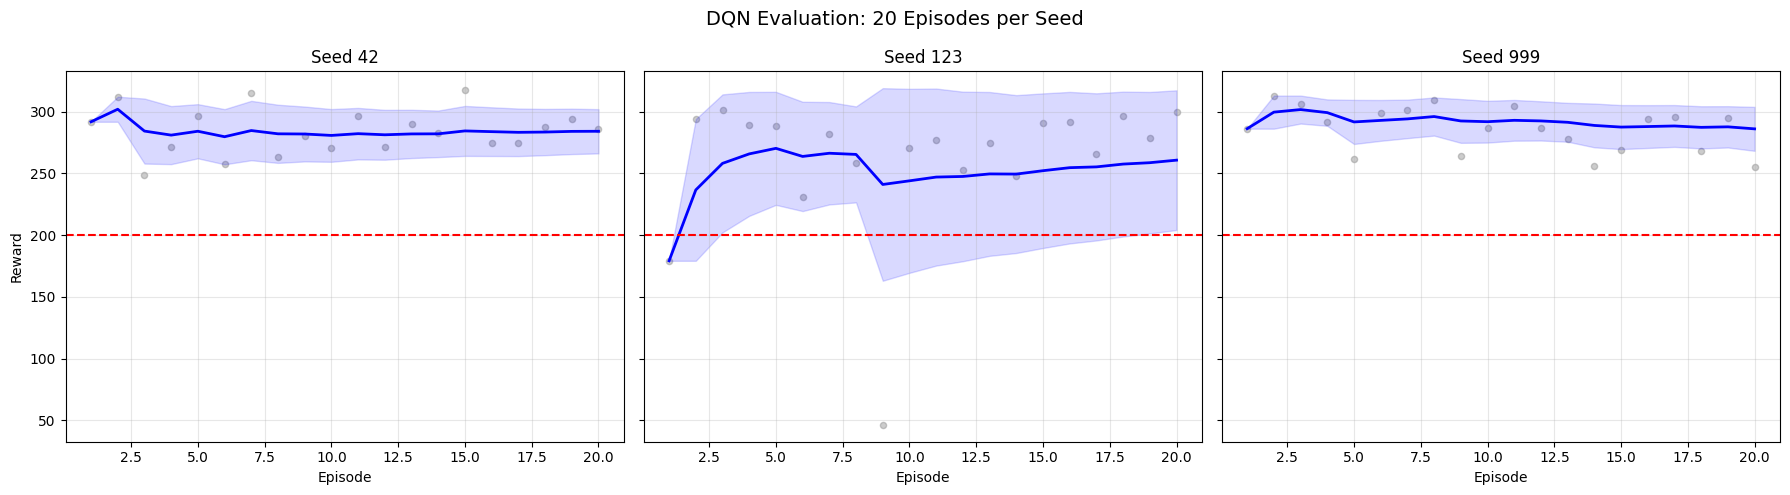

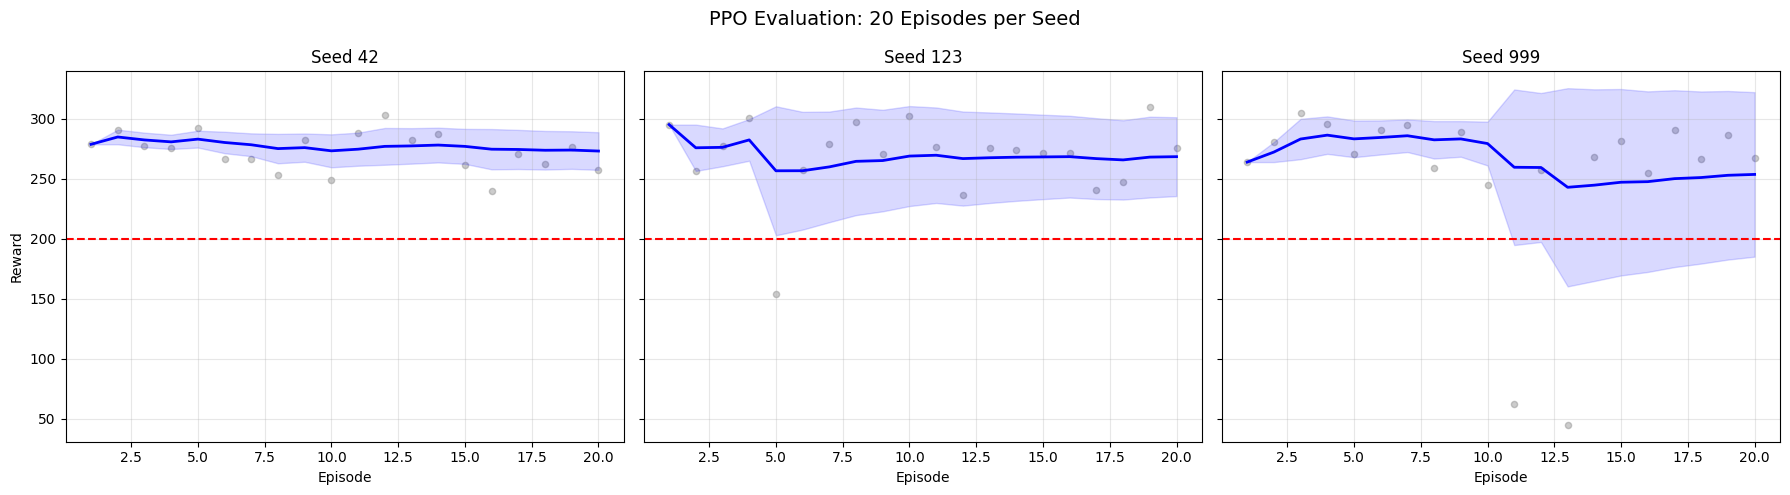

In [5]:
# Per-Algorithm, Per-Seed: Evaluation Convergence Plots

for algo_name in ALGORITHM_MAP:
    fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
    if len(SEED_LIST) == 1:
        axes = [axes]

    for ax, seed in zip(axes, SEED_LIST):
        rewards = evaluation_results[algo_name][seed]
        episodes = np.arange(1, len(rewards) + 1)
        running_mean = np.cumsum(rewards) / episodes
        running_std = np.array([np.std(rewards[:i]) for i in episodes])

        ax.scatter(episodes, rewards, color='gray', alpha=0.4, s=20, label='Episode Reward')
        ax.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
        ax.fill_between(episodes, running_mean - running_std, running_mean + running_std,
                        color='blue', alpha=0.15)
        ax.axhline(y=200, color='red', linestyle='--')
        ax.set_title(f"Seed {seed}")
        ax.set_xlabel("Episode")
        ax.grid(True, alpha=0.3)

    axes[0].set_ylabel("Reward")
    fig.suptitle(f"{algo_name.upper()} Evaluation: {EVALUATION_EPISODES} Episodes per Seed", fontsize=14)
    plt.tight_layout()
    plt.show()

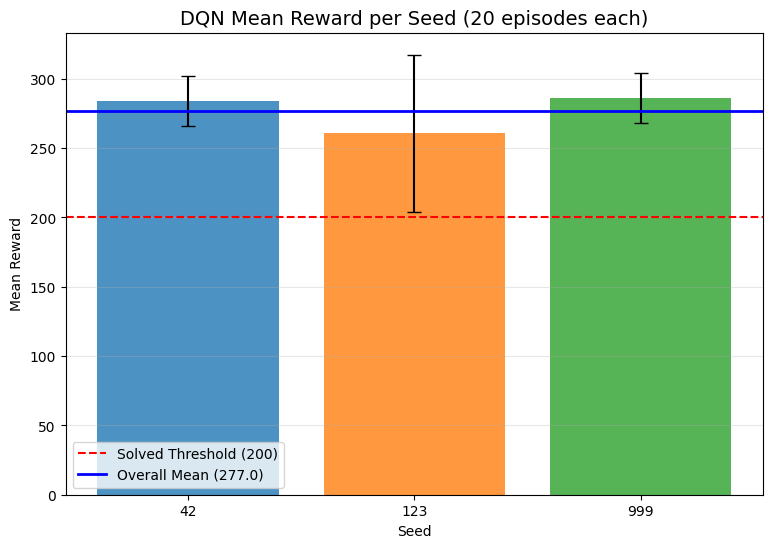

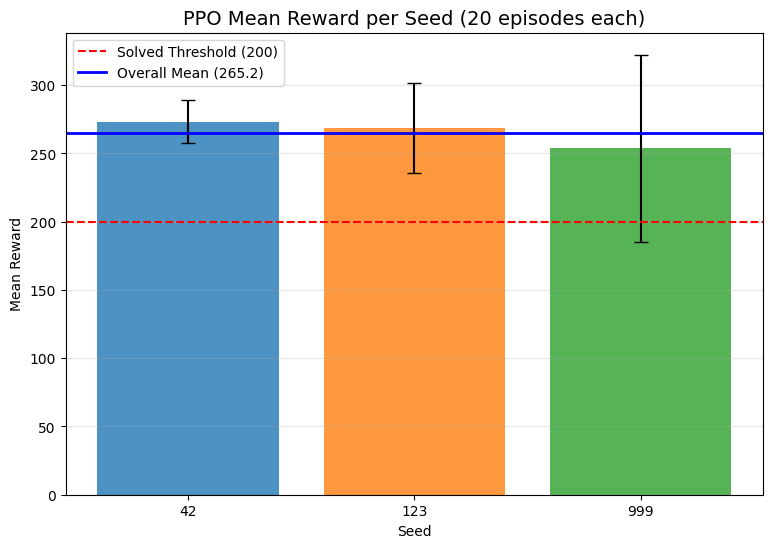

In [6]:
# Per-Algorithm: Evaluation Bar Chart (mean reward per seed with error bars)

seed_colors = list(plt.colormaps["tab10"](range(10)))  # type: ignore[arg-type]

for algo_name in ALGORITHM_MAP:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    means = [np.mean(evaluation_results[algo_name][s]) for s in SEED_LIST]
    stds = [np.std(evaluation_results[algo_name][s]) for s in SEED_LIST]
    labels = [str(s) for s in SEED_LIST]

    plt.figure(figsize=(max(8, 3 * len(SEED_LIST)), 6))
    plt.bar(labels, means, yerr=stds, capsize=5, color=seed_colors[:len(SEED_LIST)], alpha=0.8)
    plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
    plt.axhline(y=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
                label=f'Overall Mean ({np.mean(all_r):.1f})')

    plt.title(f"{algo_name.upper()} Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
    plt.xlabel("Seed")
    plt.ylabel("Mean Reward")
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    plt.show()

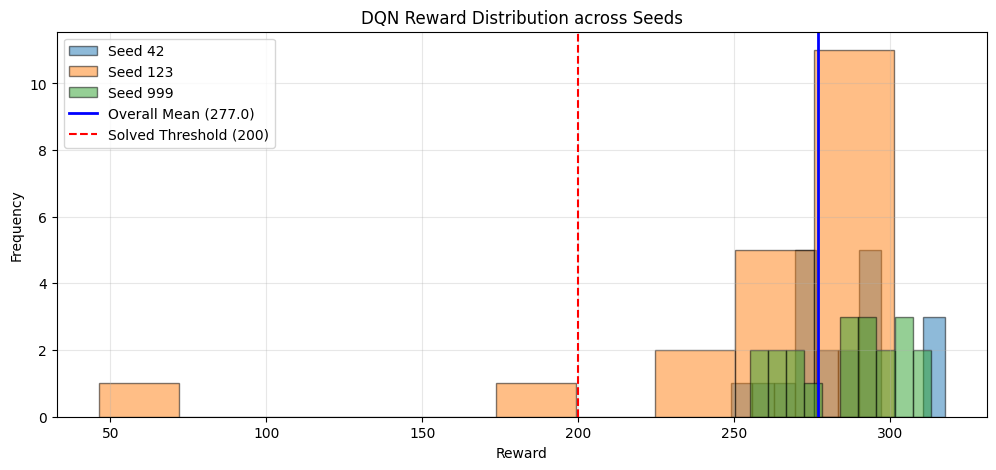

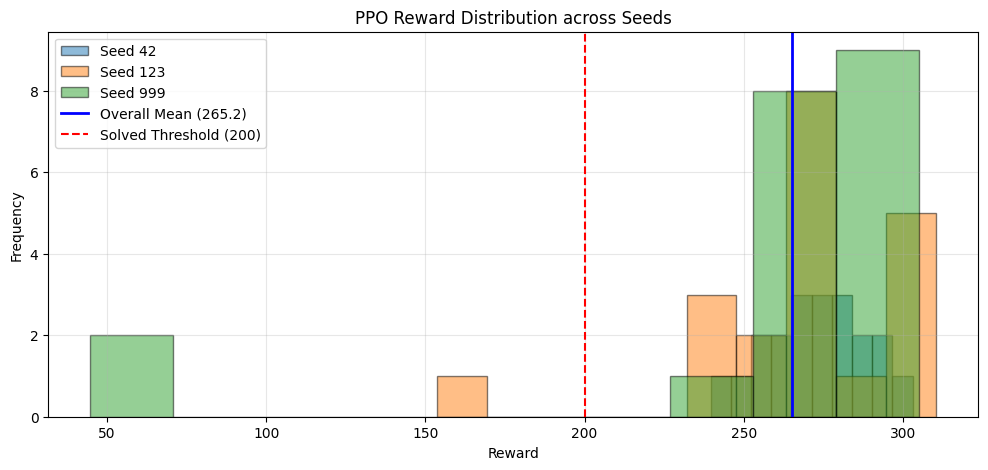

In [7]:
# Per-Algorithm: Reward Distribution Histograms (overlaid per seed)

for algo_name in ALGORITHM_MAP:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])

    plt.figure(figsize=(12, 5))
    for i, seed in enumerate(SEED_LIST):
        plt.hist(evaluation_results[algo_name][seed], bins=10, alpha=0.5,
                 color=seed_colors[i], edgecolor='black', label=f"Seed {seed}")

    plt.axvline(x=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
                label=f'Overall Mean ({np.mean(all_r):.1f})')
    plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
    plt.title(f'{algo_name.upper()} Reward Distribution across Seeds')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

---

## Cross-Algorithm Comparison

In [8]:
# Cross-Algorithm: Combined Summary Table

rows = []
for algo_name in ALGORITHM_MAP:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    rows.append({
        "Algorithm": algo_name.upper(),
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min Reward": f"{np.min(all_r):.2f}",
        "Max Reward": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })

print(f"*** CROSS-ALGORITHM EVALUATION SUMMARY ***")
print(f"Seeds: {SEED_LIST} | Episodes per seed: {EVALUATION_EPISODES}")
print(f"Total episodes per algorithm: {EVALUATION_EPISODES * len(SEED_LIST)}")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** CROSS-ALGORITHM EVALUATION SUMMARY ***
Seeds: [42, 123, 999] | Episodes per seed: 20
Total episodes per algorithm: 60

Algorithm Mean Reward Std Dev Min Reward Max Reward Success Rate
      DQN      277.01   37.57      46.40     317.48        96.7%
      PPO      265.18   45.62      44.79     310.35        95.0%


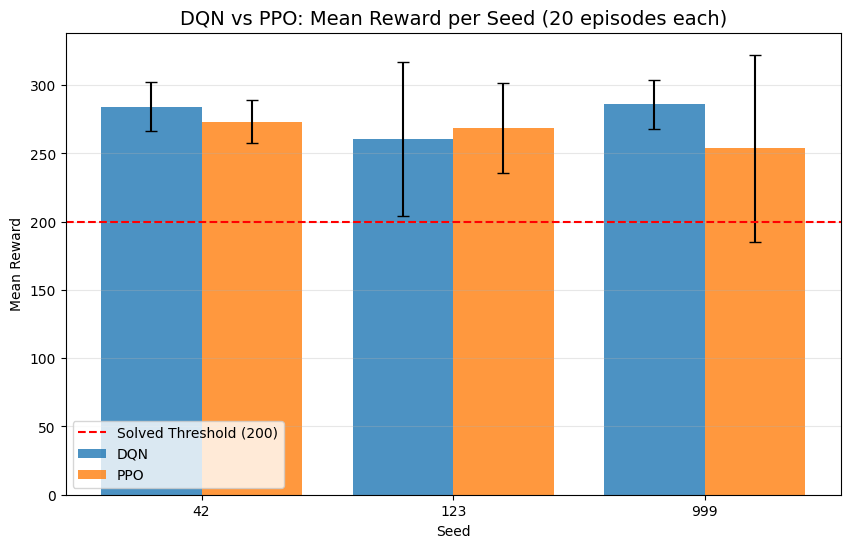

In [9]:
# Cross-Algorithm: Grouped Bar Chart (DQN vs PPO per seed)

algo_names = list(ALGORITHM_MAP.keys())
n_algos = len(algo_names)
n_seeds = len(SEED_LIST)
bar_width = 0.8 / n_algos
x = np.arange(n_seeds)

plt.figure(figsize=(max(10, 3 * n_seeds), 6))
for i, algo_name in enumerate(algo_names):
    means = [np.mean(evaluation_results[algo_name][s]) for s in SEED_LIST]
    stds = [np.std(evaluation_results[algo_name][s]) for s in SEED_LIST]
    offset = (i - (n_algos - 1) / 2) * bar_width
    plt.bar(x + offset, means, bar_width, yerr=stds, capsize=4,
            label=algo_name.upper(), alpha=0.8)

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.xticks(x, [str(s) for s in SEED_LIST])
plt.title(f"DQN vs PPO: Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

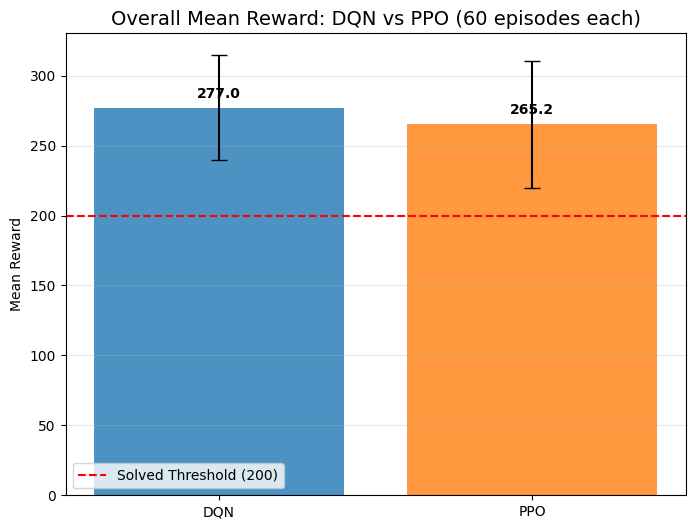

In [10]:
# Cross-Algorithm: Overall Mean Reward Bar Chart

algo_colors = {"dqn": "tab:blue", "ppo": "tab:orange"}

overall_means = []
overall_stds = []
for algo_name in algo_names:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    overall_means.append(np.mean(all_r))
    overall_stds.append(np.std(all_r))

plt.figure(figsize=(8, 6))
bars = plt.bar([a.upper() for a in algo_names], overall_means, yerr=overall_stds,
               capsize=6, color=[algo_colors[a] for a in algo_names], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

for bar, mean in zip(bars, overall_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title(f"Overall Mean Reward: DQN vs PPO ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

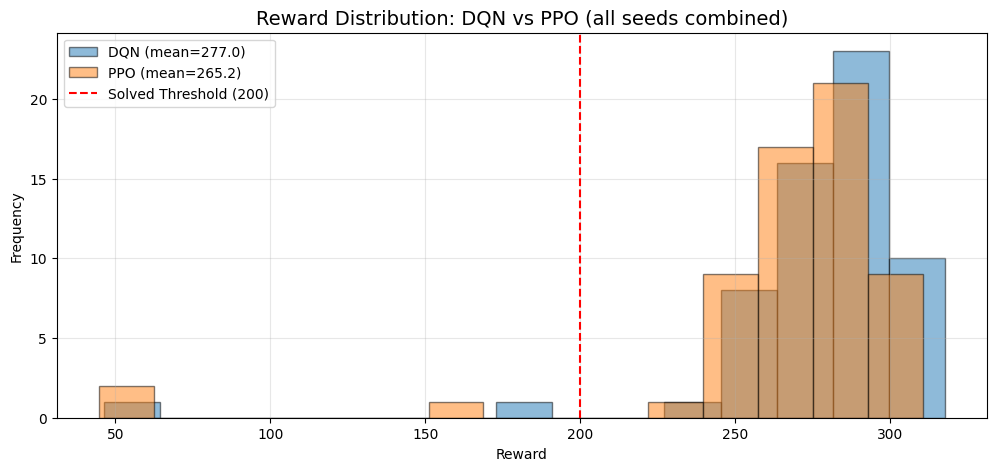

In [11]:
# Cross-Algorithm: Reward Distribution Comparison (overlaid histograms)

plt.figure(figsize=(12, 5))
for algo_name in algo_names:
    all_r = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])
    plt.hist(all_r, bins=15, alpha=0.5, color=algo_colors[algo_name],
             edgecolor='black', label=f"{algo_name.upper()} (mean={np.mean(all_r):.1f})")

plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title('Reward Distribution: DQN vs PPO (all seeds combined)', fontsize=14)
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipykernel_683766/3208474440.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)
/tmp/ipykernel_683766/3208474440.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)
/tmp/ipykernel_683766/3208474440.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)


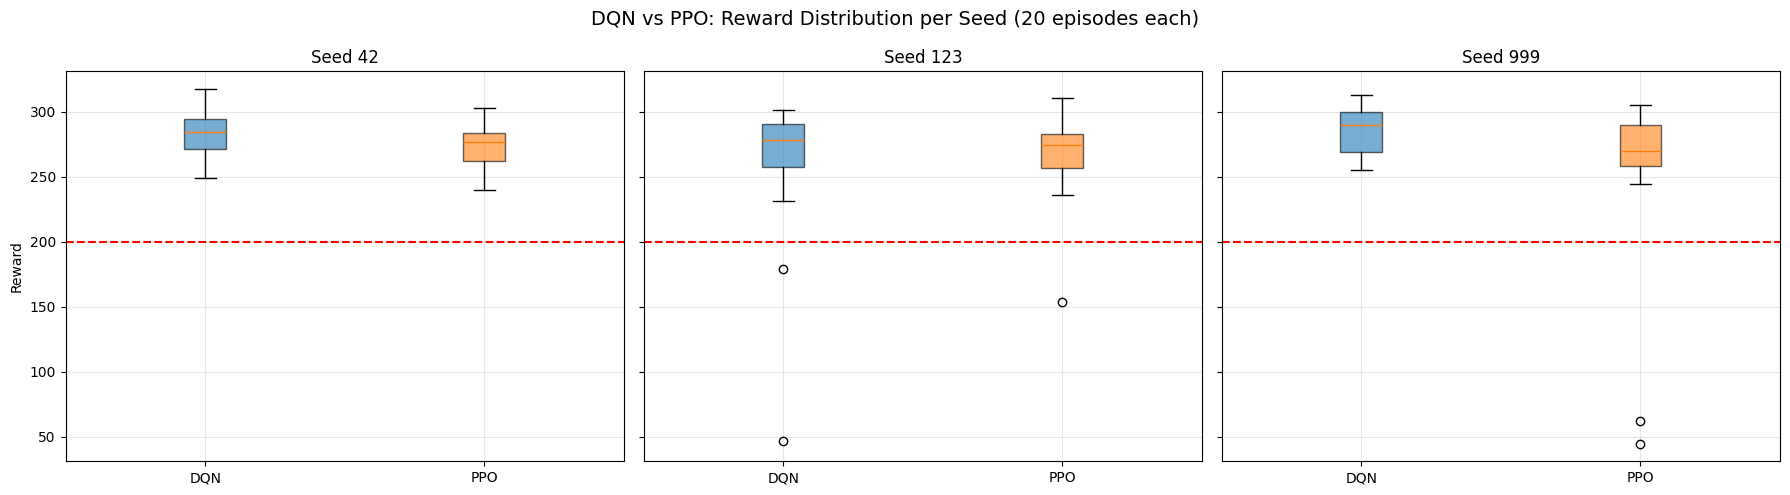

In [12]:
# Cross-Algorithm: Box Plot Comparison per Seed

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    data = [evaluation_results[algo_name][seed] for algo_name in algo_names]
    bp = ax.boxplot(data, labels=[a.upper() for a in algo_names], patch_artist=True)
    for patch, algo_name in zip(bp['boxes'], algo_names):
        patch.set_facecolor(algo_colors[algo_name])
        patch.set_alpha(0.6)
    ax.axhline(y=200, color='red', linestyle='--')
    ax.set_title(f"Seed {seed}")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle(f"DQN vs PPO: Reward Distribution per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

---

## Statistical Significance

In [13]:
# Statistical Significance: Mann-Whitney U Tests

algo_names = list(ALGORITHM_MAP.keys())

# Gather all rewards per algorithm
algo_all_rewards = {}
for algo_name in algo_names:
    algo_all_rewards[algo_name] = np.concatenate([evaluation_results[algo_name][s] for s in SEED_LIST])

# --- Reward comparison (Mann-Whitney U) ---
mwu_result = stats.mannwhitneyu(
    algo_all_rewards[algo_names[0]],
    algo_all_rewards[algo_names[1]],
    alternative='two-sided'
)
stat_reward = float(mwu_result.statistic)
p_reward = float(mwu_result.pvalue)

# --- Success rate comparison (Chi-squared) ---
successes = []
totals = []
for algo_name in algo_names:
    r = algo_all_rewards[algo_name]
    successes.append(int((r >= 200).sum()))
    totals.append(len(r))

failures = [t - s for t, s in zip(totals, successes)]
contingency = np.array([successes, failures])

# Chi-squared requires all expected frequencies > 0; skip if any row/col is all-zero
if np.all(contingency.sum(axis=1) > 0) and np.all(contingency.sum(axis=0) > 0):
    chi2_result = stats.chi2_contingency(contingency)
    chi2 = float(chi2_result[0])      # type: ignore[arg-type]  # statistic
    p_success = float(chi2_result[1])  # type: ignore[arg-type]  # pvalue
    chi2_valid = True
else:
    chi2, p_success = 0.0, 1.0
    chi2_valid = False

# --- Results table ---
chi2_note = "" if chi2_valid else " (skipped: zero row/col)"
rows = [
    {
        "Metric": "Mean Reward",
        f"{algo_names[0].upper()} Value": f"{np.mean(algo_all_rewards[algo_names[0]]):.2f}",
        f"{algo_names[1].upper()} Value": f"{np.mean(algo_all_rewards[algo_names[1]]):.2f}",
        "Test": "Mann-Whitney U",
        "Statistic": f"{stat_reward:.1f}",
        "p-value": f"{p_reward:.4f}",
        "Significant (p<0.05)": "Yes" if p_reward < 0.05 else "No"
    },
    {
        "Metric": "Success Rate (>=200)",
        f"{algo_names[0].upper()} Value": f"{successes[0]/totals[0]*100:.1f}%",
        f"{algo_names[1].upper()} Value": f"{successes[1]/totals[1]*100:.1f}%",
        "Test": f"Chi-squared{chi2_note}",
        "Statistic": f"{chi2:.2f}",
        "p-value": f"{p_success:.4f}",
        "Significant (p<0.05)": "Yes" if (chi2_valid and p_success < 0.05) else "No"
    },
]

print("*** STATISTICAL SIGNIFICANCE TESTS ***")
print(f"Sample size per algorithm: {totals[0]} episodes ({EVALUATION_EPISODES} episodes x {len(SEED_LIST)} seeds)")
print()
print(pd.DataFrame(rows).to_string(index=False))
print()
if not chi2_valid:
    print("Note: Chi-squared test skipped because one or both algorithms had 0% or 100% success rate.")
    print("      This is expected during smoke tests with few episodes. Full run will have enough data.")
    print()
if p_reward < 0.05:
    print(f"The reward difference between {algo_names[0].upper()} and {algo_names[1].upper()} is statistically significant (p={p_reward:.4f}).")
else:
    print(f"No statistically significant reward difference between {algo_names[0].upper()} and {algo_names[1].upper()} (p={p_reward:.4f}).")

*** STATISTICAL SIGNIFICANCE TESTS ***
Sample size per algorithm: 60 episodes (20 episodes x 3 seeds)

              Metric DQN Value PPO Value           Test Statistic p-value Significant (p<0.05)
         Mean Reward    277.01    265.18 Mann-Whitney U    2243.0  0.0202                  Yes
Success Rate (>=200)     96.7%     95.0%    Chi-squared      0.00  1.0000                   No

The reward difference between DQN and PPO is statistically significant (p=0.0202).


---

## Baseline Comparison

In [14]:
# Random Agent Baseline Evaluation

random_results = {}

for seed in SEED_LIST:
    print(f"Running random agent with seed {seed}...")
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    env.action_space.seed(seed)
    episode_rewards = []

    for ep in range(EVALUATION_EPISODES):
        obs, info = env.reset(seed=seed + ep)
        total_reward = 0.0
        done = False

        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += float(reward)
            done = terminated or truncated

        episode_rewards.append(total_reward)

    random_results[seed] = np.array(episode_rewards)
    env.close()

print("Random baseline evaluation complete.")

Running random agent with seed 42...
Running random agent with seed 123...
Running random agent with seed 999...
Random baseline evaluation complete.


*** BASELINE COMPARISON ***
      Agent Mean Reward Std Dev     Min    Max Success Rate
     Random     -205.65  109.48 -420.28  15.45         0.0%
        DQN      277.01   37.57   46.40 317.48        96.7%
        PPO      265.18   45.62   44.79 310.35        95.0%
Human (ref)    ~200-300       -       -      -        ~100%



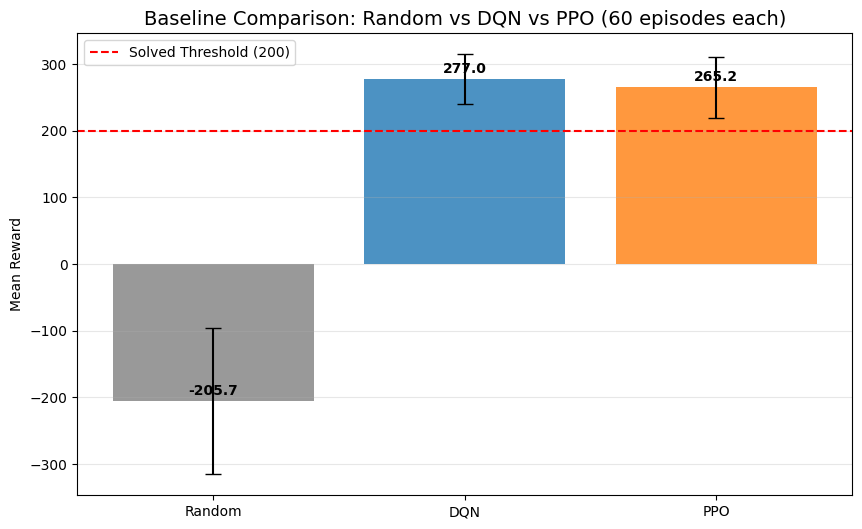

In [15]:
# Baseline Comparison: Table + Chart

algo_names = list(ALGORITHM_MAP.keys())
algo_colors = {"dqn": "tab:blue", "ppo": "tab:orange"}
algo_all_rewards = {a: np.concatenate([evaluation_results[a][s] for s in SEED_LIST]) for a in algo_names}

all_random = np.concatenate([random_results[s] for s in SEED_LIST])

rows = [
    {
        "Agent": "Random",
        "Mean Reward": f"{np.mean(all_random):.2f}",
        "Std Dev": f"{np.std(all_random):.2f}",
        "Min": f"{np.min(all_random):.2f}",
        "Max": f"{np.max(all_random):.2f}",
        "Success Rate": f"{(all_random >= 200).sum() / len(all_random) * 100:.1f}%"
    }
]
for algo_name in algo_names:
    all_r = algo_all_rewards[algo_name]
    rows.append({
        "Agent": algo_name.upper(),
        "Mean Reward": f"{np.mean(all_r):.2f}",
        "Std Dev": f"{np.std(all_r):.2f}",
        "Min": f"{np.min(all_r):.2f}",
        "Max": f"{np.max(all_r):.2f}",
        "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
    })
rows.append({
    "Agent": "Human (ref)",
    "Mean Reward": "~200-300",
    "Std Dev": "-",
    "Min": "-",
    "Max": "-",
    "Success Rate": "~100%"
})

print("*** BASELINE COMPARISON ***")
print(pd.DataFrame(rows).to_string(index=False))
print()

# Bar chart
agent_labels = ["Random"] + [a.upper() for a in algo_names]
agent_means = [np.mean(all_random)] + [np.mean(algo_all_rewards[a]) for a in algo_names]
agent_stds = [np.std(all_random)] + [np.std(algo_all_rewards[a]) for a in algo_names]
bar_colors = ["gray"] + [algo_colors[a] for a in algo_names]

plt.figure(figsize=(10, 6))
bars = plt.bar(agent_labels, agent_means, yerr=agent_stds, capsize=6,
               color=bar_colors, alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

for bar, mean in zip(bars, agent_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title(f"Baseline Comparison: Random vs DQN vs PPO ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

---

## Agent Behavior Analysis

In [16]:
# Collect per-step data: actions and trajectories

action_counts = {}       # {algo: np.array of shape (4,)} total action counts
trajectory_data = {}     # {algo: list of (x_positions, y_positions)} one per TRAJECTORY_EPISODES

for algo_name, algo_class in ALGORITHM_MAP.items():
    action_counts[algo_name] = np.zeros(len(ACTION_LABELS), dtype=int)
    trajectory_data[algo_name] = []

    for seed in SEED_LIST:
        load_path = best_model_paths.get(algo_name, {}).get(seed)
        if load_path is None:
            continue

        def make_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        model = algo_class.load(load_path, env=DummyVecEnv([make_env]), device=DEVICE)
        env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)

        for ep in range(EVALUATION_EPISODES):
            obs, info = env.reset(seed=seed + ep)
            done = False
            x_pos, y_pos = [obs[0]], [obs[1]]

            while not done:
                action, _ = model.predict(obs, deterministic=True)
                action_int = int(action)
                action_counts[algo_name][action_int] += 1

                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated
                x_pos.append(obs[0])
                y_pos.append(obs[1])

            # Keep trajectory for the first TRAJECTORY_EPISODES episodes of the first seed
            if seed == SEED_LIST[0] and ep < TRAJECTORY_EPISODES:
                trajectory_data[algo_name].append((np.array(x_pos), np.array(y_pos)))

        env.close()

    total_actions = action_counts[algo_name].sum()
    print(f"{algo_name.upper()}: {total_actions:,} total actions collected across {EVALUATION_EPISODES * len(SEED_LIST)} episodes")

print("\nBehavior data collection complete.")


DQN: 13,623 total actions collected across 60 episodes
PPO: 16,645 total actions collected across 60 episodes

Behavior data collection complete.


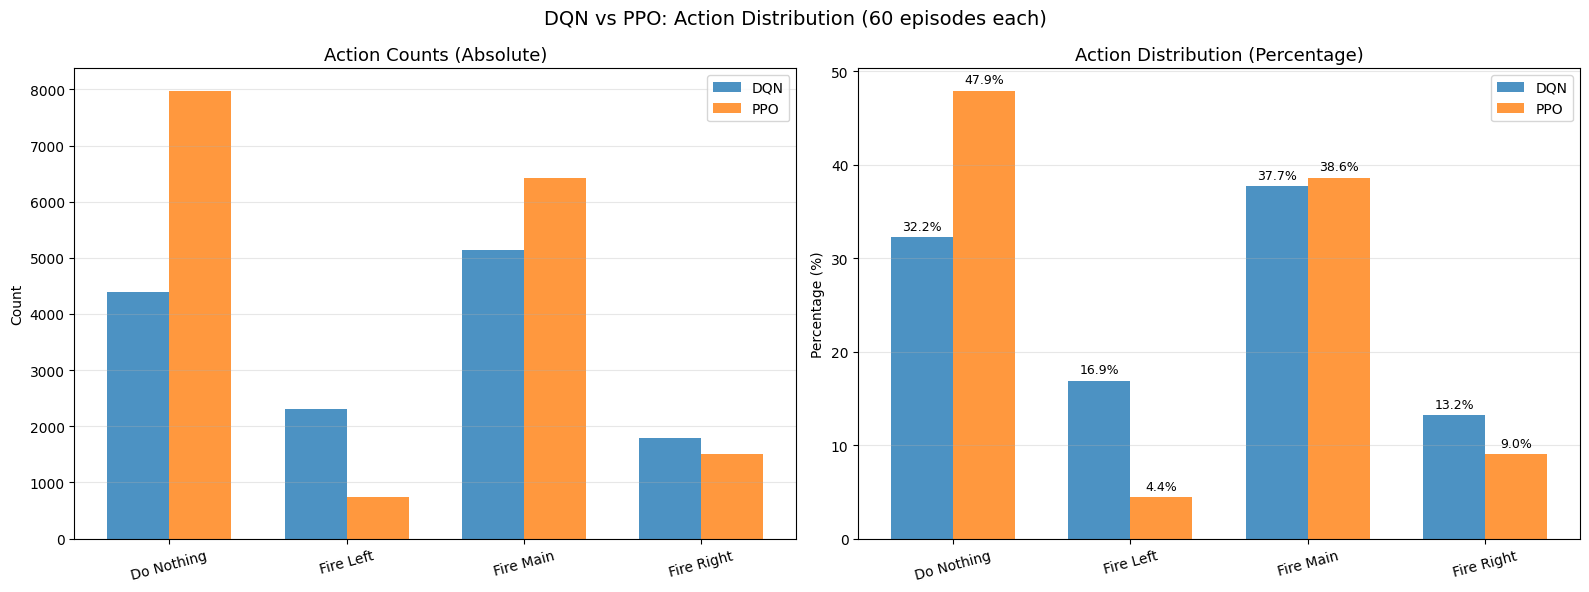

In [17]:
# Action Distribution: DQN vs PPO

n_actions = len(ACTION_LABELS)
x = np.arange(n_actions)
bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
for i, algo_name in enumerate(algo_names):
    offset = (i - 0.5) * bar_width
    ax1.bar(x + offset, action_counts[algo_name], bar_width,
            label=algo_name.upper(), color=algo_colors[algo_name], alpha=0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(ACTION_LABELS, rotation=15)
ax1.set_title("Action Counts (Absolute)", fontsize=13)
ax1.set_ylabel("Count")
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Percentage distribution
for i, algo_name in enumerate(algo_names):
    pcts = action_counts[algo_name] / action_counts[algo_name].sum() * 100
    offset = (i - 0.5) * bar_width
    bars = ax2.bar(x + offset, pcts, bar_width,
                   label=algo_name.upper(), color=algo_colors[algo_name], alpha=0.8)
    for bar, pct in zip(bars, pcts):
        ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.set_xticks(x)
ax2.set_xticklabels(ACTION_LABELS, rotation=15)
ax2.set_title("Action Distribution (Percentage)", fontsize=13)
ax2.set_ylabel("Percentage (%)")
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle(f"DQN vs PPO: Action Distribution ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

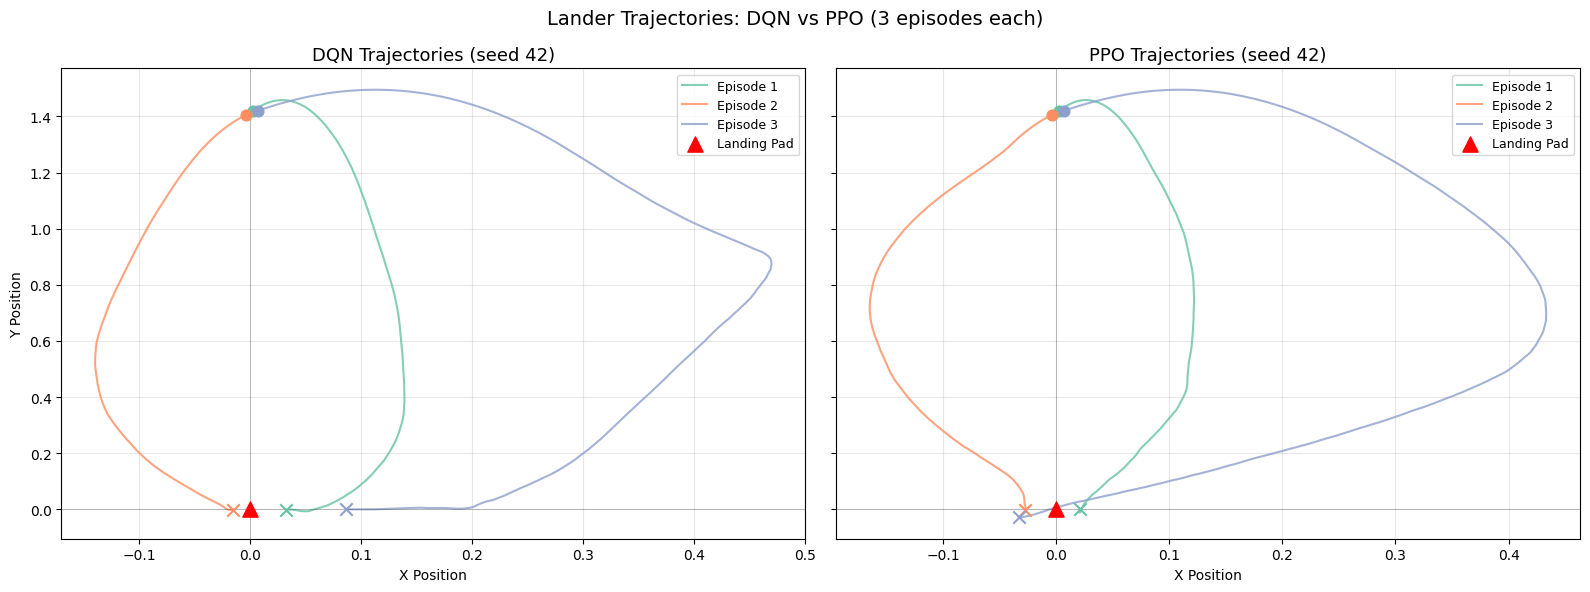

In [18]:
# Trajectory Plots: x-y paths of the lander

fig, axes = plt.subplots(1, len(algo_names), figsize=(8 * len(algo_names), 6), sharey=True)
if len(algo_names) == 1:
    axes = [axes]

traj_colors = list(plt.colormaps["Set2"](range(8)))  # type: ignore[arg-type]

for ax, algo_name in zip(axes, algo_names):
    for i, (x_pos, y_pos) in enumerate(trajectory_data[algo_name]):
        ax.plot(x_pos, y_pos, color=traj_colors[i], linewidth=1.5, alpha=0.8,
                label=f"Episode {i+1}")
        ax.scatter(x_pos[0], y_pos[0], color=traj_colors[i], marker='o', s=60, zorder=5)
        ax.scatter(x_pos[-1], y_pos[-1], color=traj_colors[i], marker='x', s=80, zorder=5)

    # Landing pad reference
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.scatter(0, 0, color='red', marker='^', s=120, zorder=10, label='Landing Pad')

    ax.set_title(f"{algo_name.upper()} Trajectories (seed {SEED_LIST[0]})", fontsize=13)
    ax.set_xlabel("X Position")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Y Position")
fig.suptitle(f"Lander Trajectories: DQN vs PPO ({TRAJECTORY_EPISODES} episodes each)", fontsize=14)
plt.tight_layout()
plt.show()

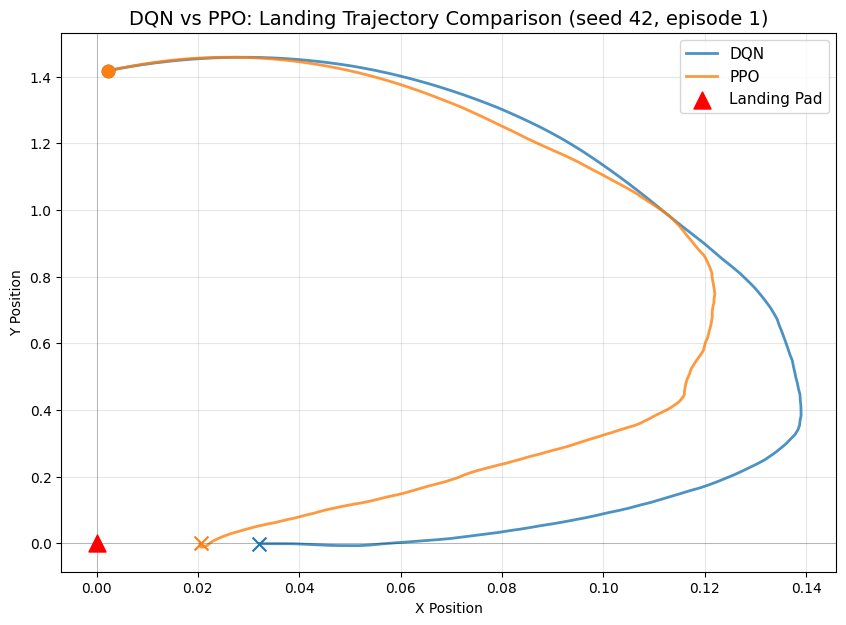

In [19]:
# Trajectory Comparison: DQN vs PPO overlaid on one chart

plt.figure(figsize=(10, 7))

for algo_name in algo_names:
    # Plot the first trajectory from each algorithm
    x_pos, y_pos = trajectory_data[algo_name][0]
    plt.plot(x_pos, y_pos, color=algo_colors[algo_name], linewidth=2, alpha=0.8,
             label=f"{algo_name.upper()}")
    plt.scatter(x_pos[0], y_pos[0], color=algo_colors[algo_name], marker='o', s=80, zorder=5)
    plt.scatter(x_pos[-1], y_pos[-1], color=algo_colors[algo_name], marker='x', s=100, zorder=5)

plt.scatter(0, 0, color='red', marker='^', s=150, zorder=10, label='Landing Pad')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

plt.title(f"DQN vs PPO: Landing Trajectory Comparison (seed {SEED_LIST[0]}, episode 1)", fontsize=14)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

---

## GIF Visualizations

Generating GIF for DQN seed 42 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_dqn/dqn_seed42.gif


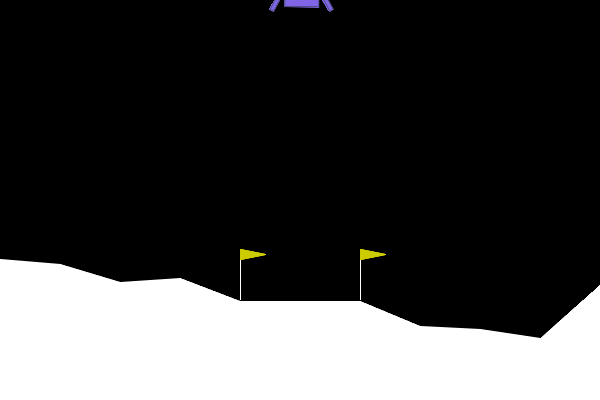

Generating GIF for DQN seed 123 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_dqn/dqn_seed123.gif


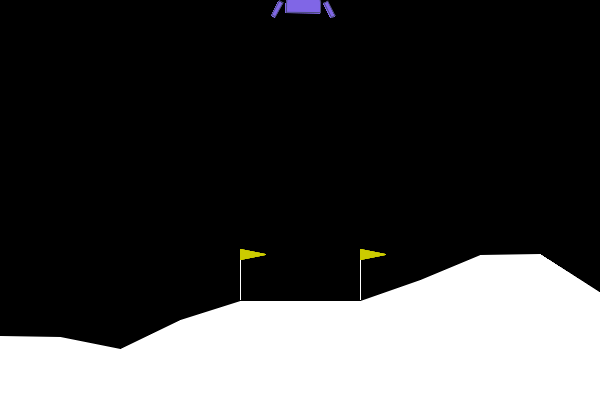

Generating GIF for DQN seed 999 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_dqn/dqn_seed999.gif


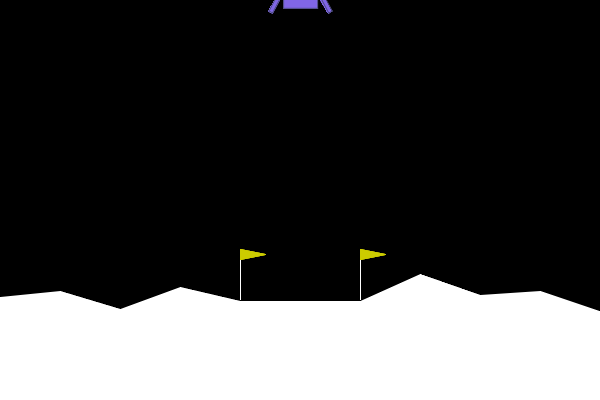

Generating GIF for PPO seed 42 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_ppo/ppo_seed42.gif


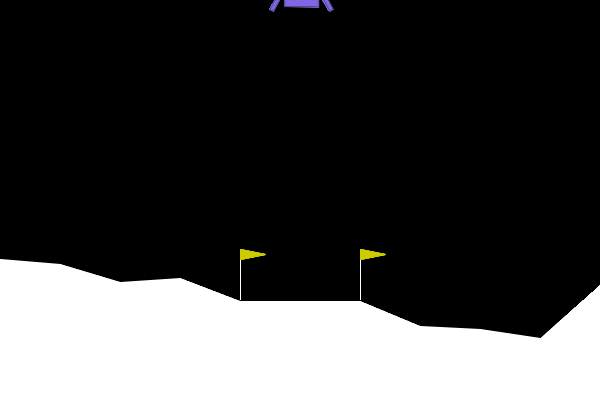

Generating GIF for PPO seed 123 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_ppo/ppo_seed123.gif


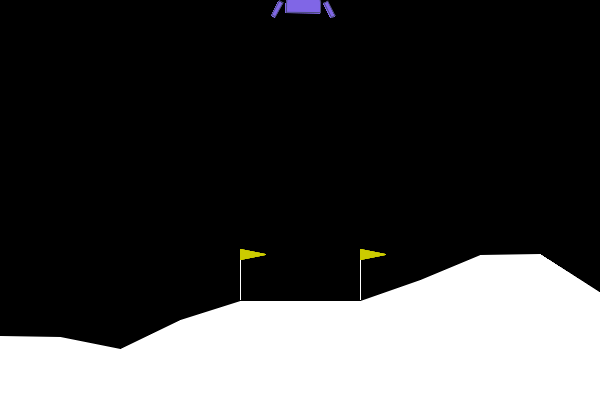

Generating GIF for PPO seed 999 (best model)...
  Saved: /home/logus/env/iscte/taap_p2/drafts/draft_01/gymnasium/outputs_ppo/ppo_seed999.gif


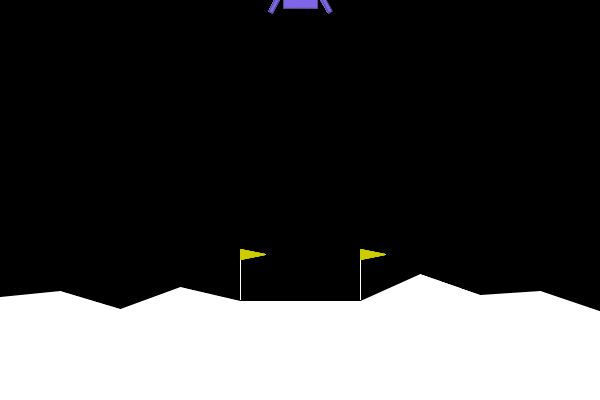

In [20]:
# GIF Visualizations (one per algorithm per seed, best model)

for algo_name, algo_class in ALGORITHM_MAP.items():
    output_dir = os.path.join(NOTEBOOK_DIR, "outputs_" + algo_name)
    os.makedirs(output_dir, exist_ok=True)

    for seed in SEED_LIST:
        load_path = best_model_paths.get(algo_name, {}).get(seed)
        if load_path is None:
            print(f"SKIPPING GIF for {algo_name.upper()} seed {seed} — best model not found")
            continue

        print(f"Generating GIF for {algo_name.upper()} seed {seed} (best model)...")

        def make_vis_env(s=seed):
            env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
            env.reset(seed=s)
            return env

        vis_model = algo_class.load(load_path, env=DummyVecEnv([make_vis_env]), device=DEVICE)

        vis_env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
        frames = []
        obs, info = vis_env.reset(seed=seed)
        done = False

        while not done:
            action, _ = vis_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = vis_env.step(action)
            done = terminated or truncated
            frames.append(vis_env.render())

        vis_env.close()

        gif_path = os.path.join(output_dir, f"{algo_name}_seed{seed}.gif")
        imageio.mimsave(gif_path, frames, fps=30)
        print(f"  Saved: {gif_path}")
        display(Image(filename=gif_path))


---

## Appendix: Experimental Setup

### Environment Details

| Property | Value |
|---|---|
| Environment | `LunarLander-v3` (Gymnasium) |
| Observation Space | `Box(8,)` — continuous 8-dimensional vector |
| Action Space | `Discrete(4)` — do nothing, fire left, fire main, fire right |
| Solved Threshold | Mean reward >= 200 over 100 consecutive episodes |
| Wind | Disabled (`enable_wind=False`) |

**Observation vector:** `[x, y, vx, vy, angle, angular_velocity, left_leg_contact, right_leg_contact]`

**Reward structure:**
- Moving toward the landing pad: positive
- Moving away: negative
- Crash: -100
- Successful landing: +100
- Each leg ground contact: +10
- Firing main engine: -0.3 per frame
- Firing side engine: -0.03 per frame

**Termination rules:**
- **Terminated (success):** The lander comes to rest on the ground with both legs in contact, near-zero velocity
- **Terminated (crash):** The lander body contacts the ground, or the lander moves outside the viewport boundaries
- **Truncated (timeout):** The episode exceeds 1000 timesteps without termination

In [21]:
# Environment inspection

env_tmp = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
print(f"Environment: {GYMNASIUM_MODEL}")
print(f"Observation space: {env_tmp.observation_space}")
print(f"Action space: {env_tmp.action_space}")
print(f"Wind enabled: {WIND_ENABLED}")

obs, info = env_tmp.reset(seed=42)
print(f"\nSample observation: {obs}")
print(f"Observation labels: [x, y, vx, vy, angle, angular_vel, left_leg, right_leg]")
env_tmp.close()

Environment: LunarLander-v3
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Wind enabled: False

Sample observation: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]
Observation labels: [x, y, vx, vy, angle, angular_vel, left_leg, right_leg]


In [22]:
# System and library versions

import stable_baselines3

print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
print(f"Stable-Baselines3: {stable_baselines3.__version__}")
print(f"Gymnasium: {gym.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Device: {DEVICE}")
print(f"CUDA: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")

Python: 3.12.3
PyTorch: 2.10.0+cu130
Stable-Baselines3: 2.7.1
Gymnasium: 1.2.3
NumPy: 2.4.2
Device: cpu
CUDA: 13.0


---